In [135]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import os
os.chdir('/Users/qianwang/Desktop/TradingChallenge')

product = "STARFRUIT"
assert product in ["AMETHYSTS", "STARFRUIT"]

df_dayminus2 = pd.read_csv('codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_-2.csv', sep=';')
product_rows = df_dayminus2["product"] == product
best_bid = df_dayminus2["bid_price_1"][product_rows].to_numpy()
best_ask = df_dayminus2["ask_price_1"][product_rows].to_numpy()

df_dayminus1 = pd.read_csv('codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_-1.csv', sep=';')
product_rows = df_dayminus1["product"] == product
best_bid = np.append(best_bid, df_dayminus1["bid_price_1"][product_rows].to_numpy())
best_ask = np.append(best_ask, df_dayminus1["ask_price_1"][product_rows].to_numpy())

df_day0 = pd.read_csv('codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_0.csv', sep=';')
product_rows = df_day0["product"] == product
best_bid = np.append(best_bid, df_day0["bid_price_1"][product_rows].to_numpy())
best_ask = np.append(best_ask, df_day0["ask_price_1"][product_rows].to_numpy())

mid_price = (best_bid + best_ask) / 2

In [122]:
filenames = ['codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_-2.csv',
             'codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_-1.csv',
             'codes/round_1/algo_trading/round-1-island-data-bottle/prices_round_1_day_0.csv']
for i, fname in enumerate(filenames):
    df = pd.read_csv(fname, sep=';')
    product_rows = df["product"] == product

    bid_price_1 = df["bid_price_1"][product_rows].fillna(0).to_numpy()
    bid_price_2 = df["bid_price_2"][product_rows].fillna(0).to_numpy()
    bid_price_3 = df["bid_price_3"][product_rows].fillna(0).to_numpy()

    bid_amount_1 = df["bid_volume_1"][product_rows].fillna(0).to_numpy()
    bid_amount_2 = df["bid_volume_2"][product_rows].fillna(0).to_numpy()
    bid_amount_3 = df["bid_volume_3"][product_rows].fillna(0).to_numpy()

    ask_price_1 = df["ask_price_1"][product_rows].fillna(0).to_numpy()
    ask_price_2 = df["ask_price_2"][product_rows].fillna(0).to_numpy()
    ask_price_3 = df["ask_price_3"][product_rows].fillna(0).to_numpy()

    ask_amount_1 = df["ask_volume_1"][product_rows].fillna(0).to_numpy()
    ask_amount_2 = df["ask_volume_2"][product_rows].fillna(0).to_numpy()
    ask_amount_3 = df["ask_volume_3"][product_rows].fillna(0).to_numpy()

    prices = np.vstack([bid_price_1, bid_price_2, bid_price_3, ask_price_1, ask_price_2, ask_price_3])
    volumes = np.vstack([bid_amount_1, bid_amount_2, bid_amount_3, ask_amount_1, ask_amount_2, ask_amount_3])

    if i == 0:
        price_ave = np.average(prices, weights=volumes, axis=0)
    else:
        price_ave = np.append(price_ave, np.average(prices, weights=volumes, axis=0))

mid_price = price_ave
    

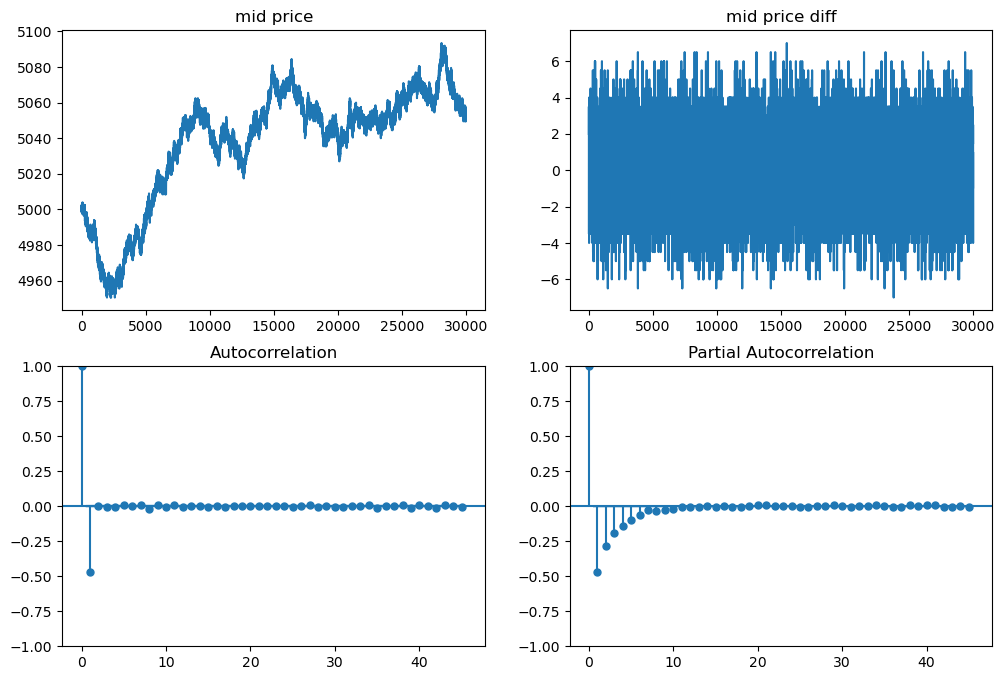

In [136]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes[0, 0].plot(mid_price)
axes[0, 0].set_title('mid price')

mid_price_diff = np.diff(mid_price)
axes[0, 1].plot(mid_price_diff)
axes[0, 1].set_title('mid price diff')

plot_acf(mid_price_diff, ax=axes[1, 0])
plot_pacf(mid_price_diff, ax=axes[1, 1])

plt.show()

In [137]:
np.std(mid_price_diff)

1.6949610240354882

In [138]:
adfuller(mid_price_diff)

(-66.87490972301237,
 0.0,
 10,
 29988,
 {'1%': -3.43056808256121,
  '5%': -2.861636386595783,
  '10%': -2.5668213036438177},
 104439.15591997244)

In [139]:
model = ARIMA(mid_price-mid_price[0], order=(0,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -52302.236
Date:                Thu, 11 Apr 2024   AIC                         104608.472
Time:                        01:26:48   BIC                         104625.090
Sample:                             0   HQIC                        104613.804
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7086      0.004   -176.818      0.000      -0.716      -0.701
sigma2         1.9137      0.013    146.455      0.000       1.888       1.939
Ljung-Box (L1) (Q):                   0.01   Jarque-

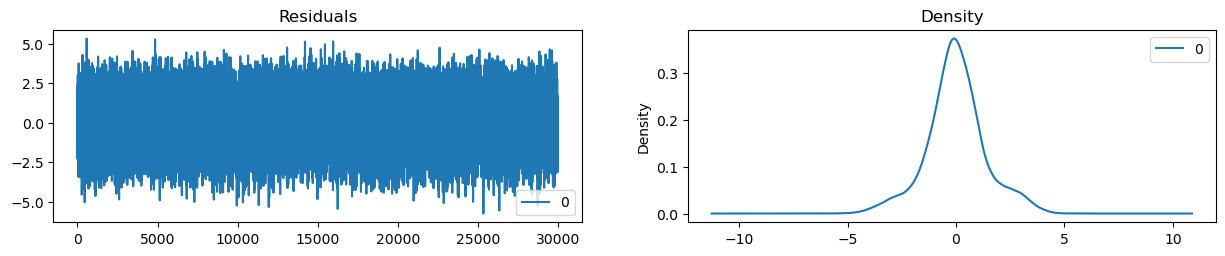

In [140]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15, 2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [141]:
np.std(residuals.to_numpy().flatten())

1.3833469575771338

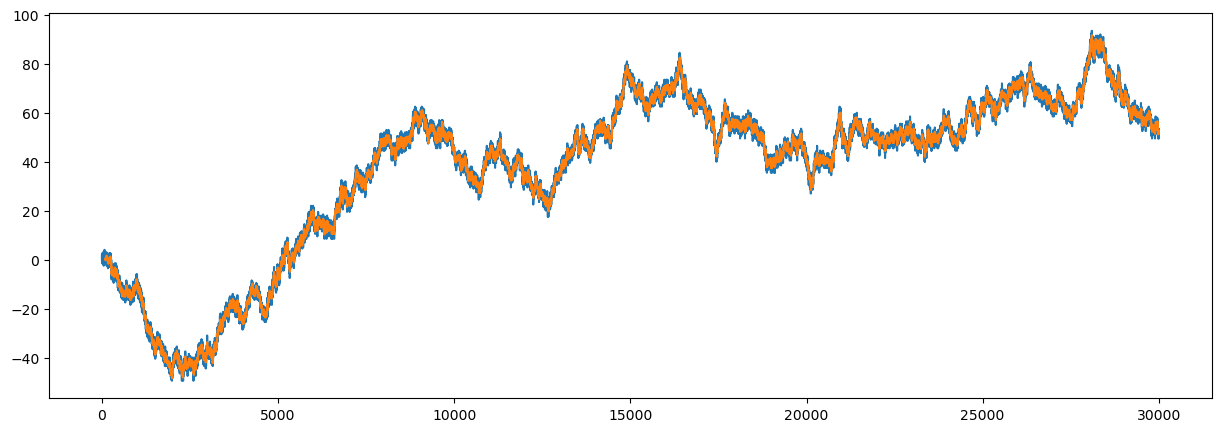

In [142]:
fig, ax = plt.subplots(figsize=(15,5))
# ax = mid_price.plot(ax=ax)
plt.plot(np.arange(len(mid_price)), mid_price - mid_price[0])
plt.plot(np.arange(100, len(mid_price)), model_fit.predict(100, len(mid_price)-1, dynamic=False))
plt.show()

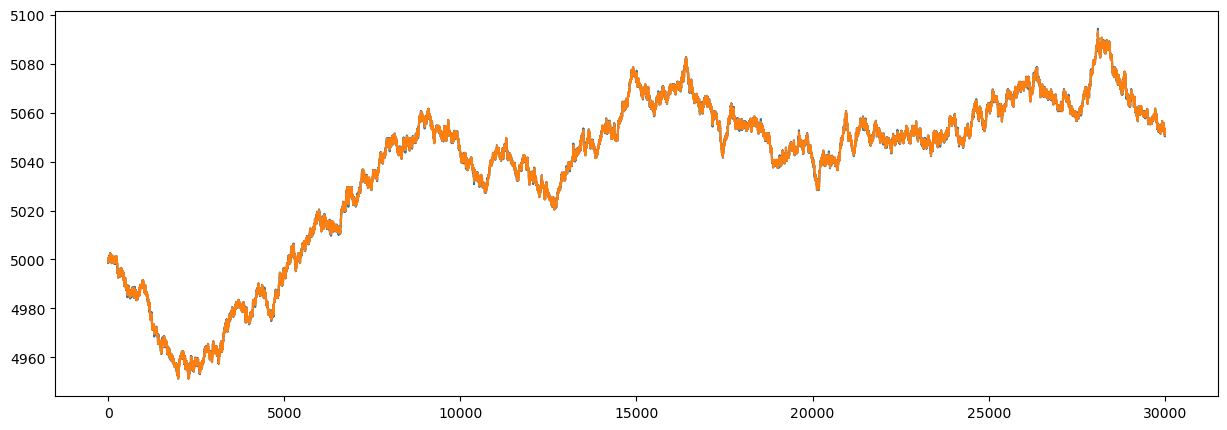

In [134]:

price_list = np.empty(len(mid_price))
price_list[0] = mid_price[0]

for i in range(len(mid_price)):

    # d = mid_price_diff[i-2]*(-0.7073) + mid_price_diff[i-3]*(-0.4919) + mid_price_diff[i-4]*(-0.3443) + mid_price_diff[i-5]*(-0.2347) + mid_price_diff[i-6]*(-0.1374) + mid_price_diff[i-7]*(-0.0612)
    if i==0:
        continue

    d = (mid_price[i-1] - price_list[i-1])*(-0.2988)
    price_list[i] = mid_price[i-1] + d

fig = plt.figure(figsize=(15,5))
plt.plot(mid_price)
plt.plot(price_list)
# plt.ylim(min(mid_price), max(mid_price))
plt.show()


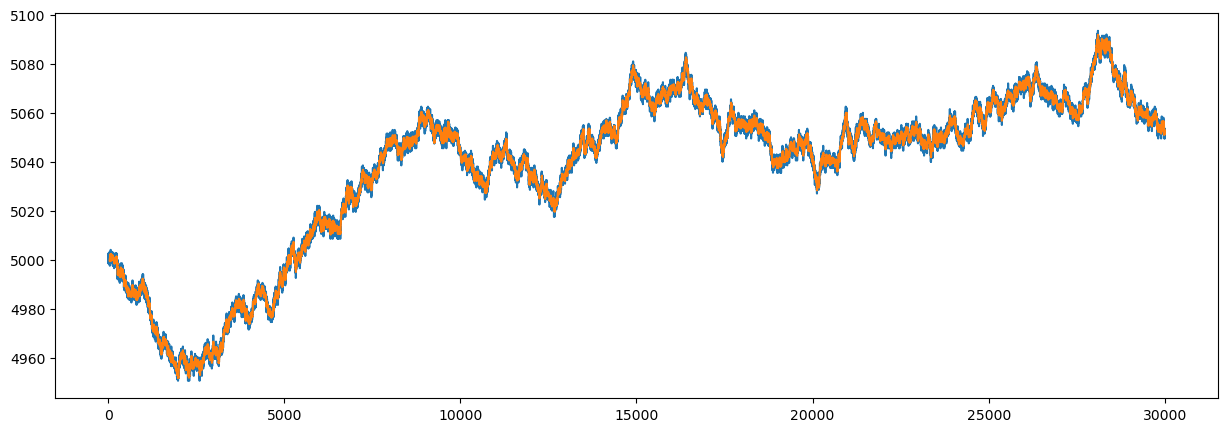

In [143]:
timestamp_list = np.arange(50, len(mid_price))
price_list = np.empty(len(timestamp_list))

for j, i in enumerate(timestamp_list):

    d = mid_price_diff[i-2]*(-0.7073) + mid_price_diff[i-3]*(-0.4919) + mid_price_diff[i-4]*(-0.3443) + mid_price_diff[i-5]*(-0.2347) + mid_price_diff[i-6]*(-0.1374) + mid_price_diff[i-7]*(-0.0612)

    price_list[j] = mid_price[i-1] + d

fig = plt.figure(figsize=(15,5))
plt.plot(mid_price)
plt.plot(timestamp_list, price_list)
plt.show()
